
📌 Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non

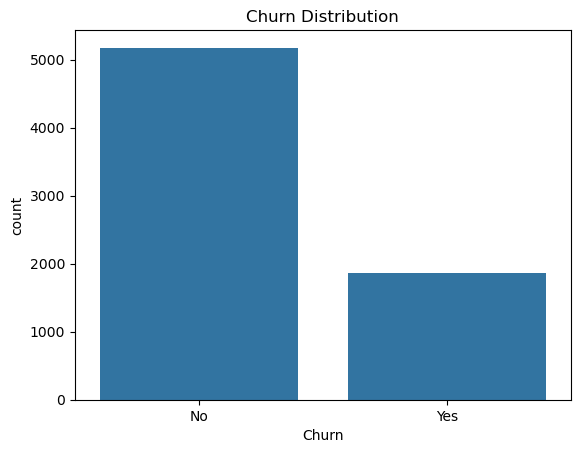

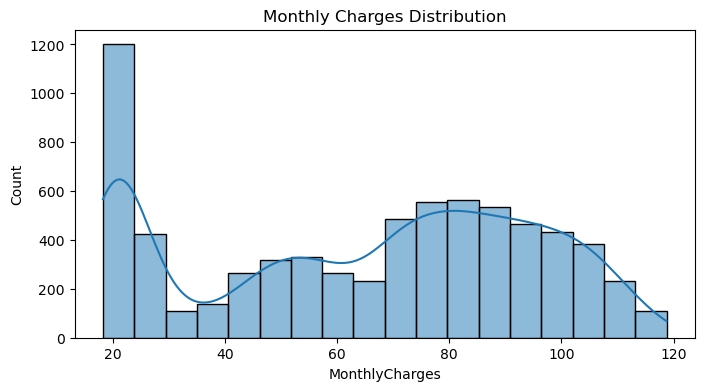

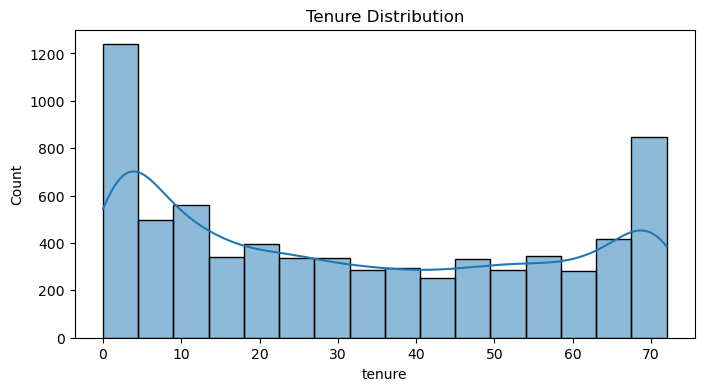

c:\Users\hisuk\03.telco_churn_project\src\preprocess.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)



Model Performance (with tuned threshold)
Best threshold: 0.33
Accuracy: 0.7686
F1 Score: 0.6192
ROC AUC Score: 0.8225


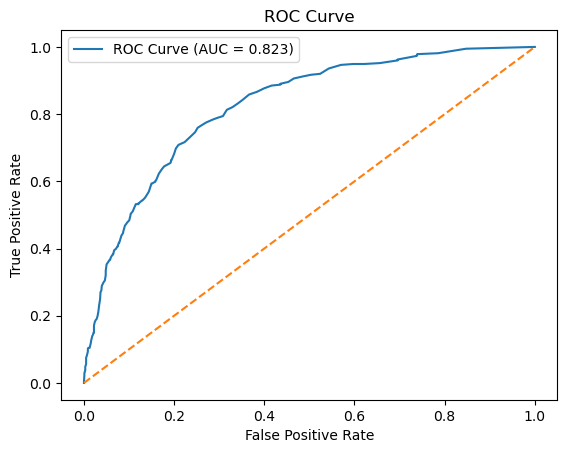

In [ ]:
import sys
from pathlib import Path
import pandas as pd

# Project root (notebook is inside /notebooks)
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Create results directory
GRAPHS_DIR = PROJECT_ROOT / "results" / "graphs"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

from src.eda import run_eda
from src.preprocess import preprocess
from src.model import train_and_evaluate

# Load data
RAW_DATA_PATH = PROJECT_ROOT / "data"
df = pd.read_csv(RAW_DATA_PATH / "WA_Fn-UseC_-Telco-Customer-Churn.csv")

# EDA (graphs saved)
df = run_eda(df, save_dir=GRAPHS_DIR)

# Preprocessing
X_train, X_test, y_train, y_test, meta_test = preprocess(df)

# Train + evaluate (graphs saved)
model, preds, probs, best_t = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    save_dir=GRAPHS_DIR
)

print("Graphs saved to:", GRAPHS_DIR)



In [ ]:
THRESHOLD = 0.50
HIGH_RISK_P = 0.70
REMAINING_MONTHS = 12
RETENTION_UPLIFT = 0.30

scored = meta_test.copy()
scored["Churn_actual"] = y_test.values
scored["churn_proba"] = probs
scored["churn_pred"] = (probs >= THRESHOLD).astype(int)

scored["risk_segment"] = pd.cut(
    scored["churn_proba"],
    [-0.01, 0.3, 0.7, 1.0],
    labels=["Low", "Medium", "High"]
)

scored["expected_revenue_loss"] = (
    scored["churn_proba"] * scored["MonthlyCharges"] * REMAINING_MONTHS
)

scored["retention_opportunity"] = (
    scored["expected_revenue_loss"] * RETENTION_UPLIFT
)

# KPI cards
kpi = pd.DataFrame([{
    "TotalCustomers": len(scored),
    "PredictedChurnRate": scored["churn_pred"].mean(),
    "HighRiskCustomerRate": (scored["churn_proba"] >= HIGH_RISK_P).mean(),
    "ExpectedRevenueLoss($)": scored["expected_revenue_loss"].sum(),
    "RetentionOpportunity($)": scored["retention_opportunity"].sum(),
}])

# Risk distribution
risk_summary = scored.groupby("risk_segment", observed=True).agg(
    customers=("customerID", "count"),
    expected_loss=("expected_revenue_loss", "sum")
).reset_index()

# Insight box numbers
high = scored[scored["churn_proba"] >= HIGH_RISK_P]
insight = pd.DataFrame([{
    "HighRiskCustomerPct": len(high) / len(scored),
    "HighRiskLossShare": high["expected_revenue_loss"].sum()
                         / scored["expected_revenue_loss"].sum()
}])

# Export for Power BI
scored.to_csv("results/scored_customers.csv", index=False)
kpi.to_csv("results/kpi_summary.csv", index=False)
risk_summary.to_csv("results/risk_summary.csv", index=False)
insight.to_csv("results/insight_summary.csv", index=False)
